# CRIME RATE PREDICTION USING ARIMAX




### Introduction to ARIMAX
The ARIMAX (AutoRegressive Integrated Moving Average with Exogenous Variables) model extends ARIMA by incorporating external factors that may influence crime rates.

Why ARIMAX?
- Crime rates are not only influenced by past values but also by socio-economic and environmental factors.
- ARIMAX allows us to capture these relationships, improving forecast accuracy.

I will compare ARIMA and ARIMAX to see if adding external variables enhances prediction accuracy.


### Data Exploration and Preprocessing

- Load the dataset and inspect its structure.
- Handle missing values and transform data if necessary.
- Ensure the time series is stationary (using ADF test).


In [1]:
# Importing the  necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

In [2]:
# Loading the dataset
file_path = "crime_prediction_dataset.csv"
df = pd.read_csv(file_path)


In [3]:
# Display basic information
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                300 non-null    object 
 1   County              300 non-null    object 
 2   Crime_Type          300 non-null    object 
 3   Reported_Cases      300 non-null    int64  
 4   Arrests             300 non-null    int64  
 5   Firearms_Recovered  300 non-null    int64  
 6   Unemployment        300 non-null    float64
 7   GDP                 300 non-null    float64
 8   Education           300 non-null    float64
dtypes: float64(3), int64(3), object(3)
memory usage: 21.2+ KB
None
         Date   County    Crime_Type  Reported_Cases  Arrests  \
0  2019-01-01  Nairobi  Drug-Related              33       14   
1  2019-01-01  Mombasa         Theft              15        7   
2  2019-01-01   Kisumu       Assault              28       11   
3  2019-01-01   Nakuru    Cyb

In [4]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())


Missing Values:
 Date                  0
County                0
Crime_Type            0
Reported_Cases        0
Arrests               0
Firearms_Recovered    0
Unemployment          0
GDP                   0
Education             0
dtype: int64


In [5]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Check time granularity (Are records daily, monthly, yearly?)
df['Date'].diff().dropna().value_counts()

0 days     240
31 days     34
30 days     20
28 days      4
29 days      1
Name: Date, dtype: int64

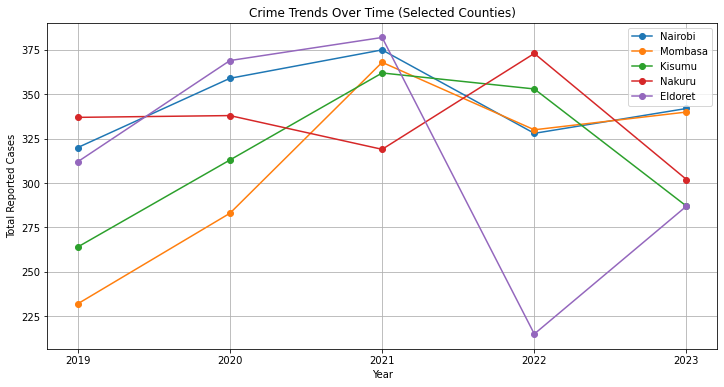

In [7]:
# Aggregate data at the yearly level
df['Year'] = df['Date'].dt.year
yearly_crime = df.groupby(['Year', 'County'])['Reported_Cases'].sum().reset_index()

# Select key counties for visualization
key_counties = ["Nairobi", "Mombasa", "Kisumu", "Nakuru", "Eldoret"]

# Plot crime trends over years
plt.figure(figsize=(12, 6))
for county in key_counties:
    county_data = yearly_crime[yearly_crime['County'] == county]
    plt.plot(county_data['Year'], county_data['Reported_Cases'], marker='o', label=county)

plt.title("Crime Trends Over Time (Selected Counties)")
plt.xlabel("Year")
plt.ylabel("Total Reported Cases")
plt.xticks(yearly_crime["Year"].unique())  # Ensure proper year spacing
plt.legend()
plt.grid(True)
plt.show()


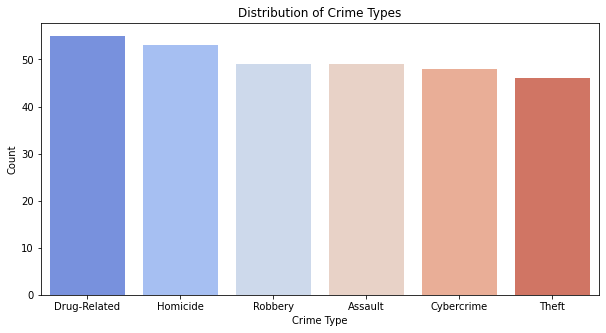

In [8]:
# Crime type distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Crime_Type", order=df["Crime_Type"].value_counts().index, palette="coolwarm")
plt.title("Distribution of Crime Types")
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.show()


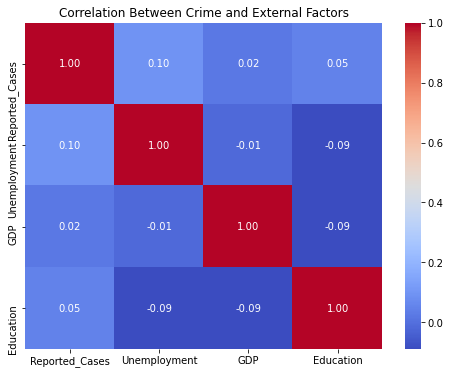

Correlation with Crime Cases:
 Unemployment    0.096856
GDP             0.024262
Education       0.051393
Name: Reported_Cases, dtype: float64


In [9]:
# Compute correlation between crime cases and exogenous variables
exog_vars = df[['Unemployment', 'GDP', 'Education']]
crime_cases = df['Reported_Cases']

# Create correlation matrix
correlation_matrix = pd.concat([crime_cases, exog_vars], axis=1).corr()

# Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Crime and External Factors")
plt.show()

# Print correlation values
print("Correlation with Crime Cases:\n", correlation_matrix["Reported_Cases"].drop("Reported_Cases"))


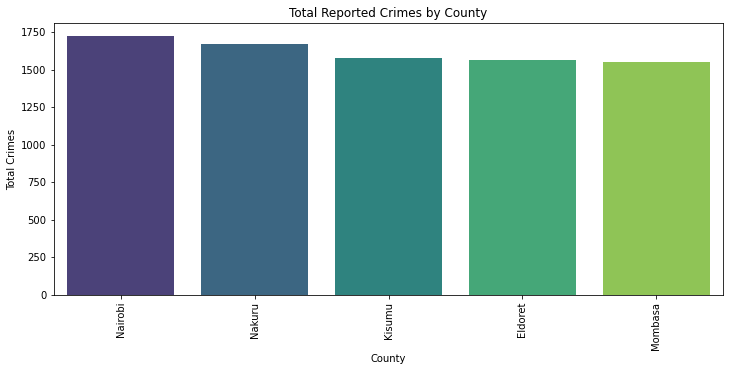

In [10]:
# Crime distribution across counties
county_crime = df.groupby("County")["Reported_Cases"].sum().reset_index().sort_values(by="Reported_Cases", ascending=False)

# Plot
plt.figure(figsize=(12,5))
sns.barplot(data=county_crime, x="County", y="Reported_Cases", palette="viridis")
plt.xticks(rotation=90)
plt.title("Total Reported Crimes by County")
plt.xlabel("County")
plt.ylabel("Total Crimes")
plt.show()


In [11]:
# Aggregate crime cases by year and county
crime_by_county_df = df.groupby(["County", "Year"])["Reported_Cases"].sum().unstack()

# Ensure both 2019 and 2023 exist before calculating growth
if 2019 in crime_by_county_df.columns and 2023 in crime_by_county_df.columns:
    # Calculate percentage crime growth from 2019 to 2023
    crime_by_county_df["Crime_Growth_%"] = ((crime_by_county_df[2023] - crime_by_county_df[2019]) / crime_by_county_df[2019]) * 100

    # Sort by highest growth
    crime_by_county_df_sorted = crime_by_county_df.sort_values(by="Crime_Growth_%", ascending=False)

    # Display top 10 counties with highest crime growth
    print(crime_by_county_df_sorted[["Crime_Growth_%"]].head(10))
else:
    print("Crime data for 2019 or 2023 is missing from the dataset.")


Year     Crime_Growth_%
County                 
Mombasa       46.551724
Kisumu         8.712121
Nairobi        6.875000
Eldoret       -8.012821
Nakuru       -10.385757


### Parameter Selection for ARIMA/ARIMAX

To build an effective ARIMA model, we need to determine the optimal values for:
- **p** (AutoRegressive order)
- **d** (Differencing order for stationarity)
- **q** (Moving Average order)

I will determine these using:
- ACF (AutoCorrelation Function) for q
- PACF (Partial AutoCorrelation Function) for p
- ADF Test for stationarity (d)


In [12]:
# Aggregate crime data at a monthly level
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_crime = df.groupby(['YearMonth', 'County'])['Reported_Cases'].sum().reset_index()
monthly_crime['YearMonth'] = monthly_crime['YearMonth'].dt.to_timestamp()

# Select Nairobi crime data
nairobi_crime = monthly_crime[monthly_crime['County'] == "Nairobi"].set_index('YearMonth')['Reported_Cases']

# ADF test for stationarity
adf_result = adfuller(nairobi_crime)
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")  # p > 0.05 means non-stationary

# Apply first-order differencing
nairobi_crime_diff = nairobi_crime.diff().dropna()


ADF Statistic: -2.4352702513453157, p-value: 0.1320280345762988


In [13]:
# Re-run ADF test after differencing
adf_result_diff = adfuller(nairobi_crime_diff)
print(f"Differenced ADF Statistic: {adf_result_diff[0]}, p-value: {adf_result_diff[1]}")

Differenced ADF Statistic: -5.0682443170174, p-value: 1.623352853635611e-05


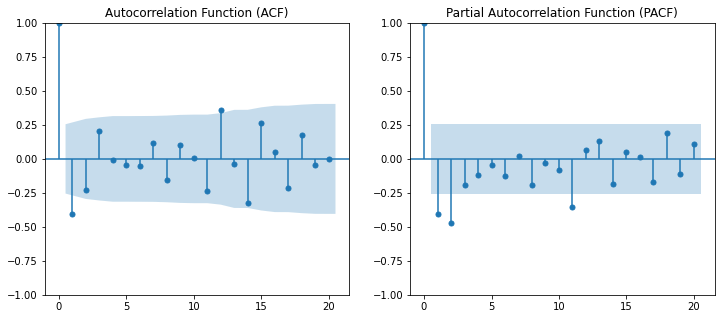

In [14]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(nairobi_crime_diff, ax=axes[0], lags=20)
axes[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(nairobi_crime_diff, ax=axes[1], lags=20)
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

 **4. Building ARIMA and ARIMAX Models**

I,ll first build a baseline ARIMA model using historical crime rates. Then, we extend it to ARIMAX by incorporating external factors.


In [15]:
# Fit ARIMA(1,1,1) as baseline
arima_model= ARIMA(nairobi_crime, order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:         Reported_Cases   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -236.228
Date:                Tue, 22 Apr 2025   AIC                            478.456
Time:                        21:41:41   BIC                            484.689
Sample:                    01-01-2019   HQIC                           480.889
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0656      0.131     -0.502      0.616      -0.322       0.191
ma.L1         -0.9994      5.502     -0.182      0.856     -11.783       9.784
sigma2       163.8245    901.200      0.182      0.8

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Get predictions for training data
predictions = arima_result.predict(start=0, end=len(nairobi_crime)-1)

# Calculate metrics
mae_value = mean_absolute_error(nairobi_crime, predictions)
rmse_value = math.sqrt(mean_squared_error(nairobi_crime, predictions))

print(f'Mean Absolute Error (MAE): {mae_value:.2f}')
print(f'Root Mean Square Error (RMSE): {rmse_value:.2f}')

Mean Absolute Error (MAE): 12.04
Root Mean Square Error (RMSE): 13.89


In [16]:
# Prepare exogenous variables for ARIMAX
exog_vars = df[df['County'] == "Nairobi"].groupby('YearMonth')[['Unemployment', 'GDP', 'Education']].mean()
exog_vars.index = exog_vars.index.to_timestamp()
exog_vars = exog_vars.reindex(nairobi_crime.index)

### Hyperparameter Tuning using AIC

I used a grid search approach to find the best (p, d, q) combination by minimizing the Akaike Information Criterion (AIC).


In [17]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt


y = nairobi_crime  
exog = exog_vars  

# Define ARIMA parameter combinations to test
param_grid = [(1,1,1), (2,1,0), (0,1,2), (2,0,2), (1,0,0)]

# Prepare results list
results = []

for order in param_grid:
    try:
        model = SARIMAX(y, exog=exog, order=order, enforce_stationarity=False, enforce_invertibility=False)
        results_model = model.fit(disp=False)

        pred = results_model.predict(start=0, end=len(y)-1, exog=exog)
        rmse = sqrt(mean_squared_error(y, pred))

        results.append({
            'order': order,
            'AIC': results_model.aic,
            'BIC': results_model.bic,
            'RMSE': rmse
        })
    except Exception as e:
        results.append({
            'order': order,
            'AIC': None,
            'BIC': None,
            'RMSE': None,
            'Error': str(e)
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


       order         AIC         BIC       RMSE
0  (1, 1, 1)  474.082167  486.340475  14.757646
1  (2, 1, 0)  480.347924  492.606232  15.389883
2  (0, 1, 2)  463.482626  475.634736  14.414183
3  (2, 0, 2)  471.810230  488.154640  13.045293
4  (1, 0, 0)  484.279841  494.667528  13.356311


In [18]:
import statsmodels.api as sm


In [28]:
# Calculate residuals and metrics
residuals = best_model1.resid
rmse = np.sqrt(np.mean(residuals ** 2))
mae = np.mean(np.abs(residuals))

# Print model summary and metrics
print("Model Summary:")
print("-" * 80)
print(best_model1.summary())
print("\nModel Performance Metrics:")
print("-" * 80)
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f}")

Model Summary:
--------------------------------------------------------------------------------
                               SARIMAX Results                                
Dep. Variable:         Reported_Cases   No. Observations:                   60
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -234.067
Date:                Tue, 22 Apr 2025   AIC                            486.134
Time:                        21:50:42   BIC                            504.983
Sample:                    01-01-2019   HQIC                           493.507
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           32.7303     13.613      2.404      0.016       6.050      59.411
Unemployment     0.4559      

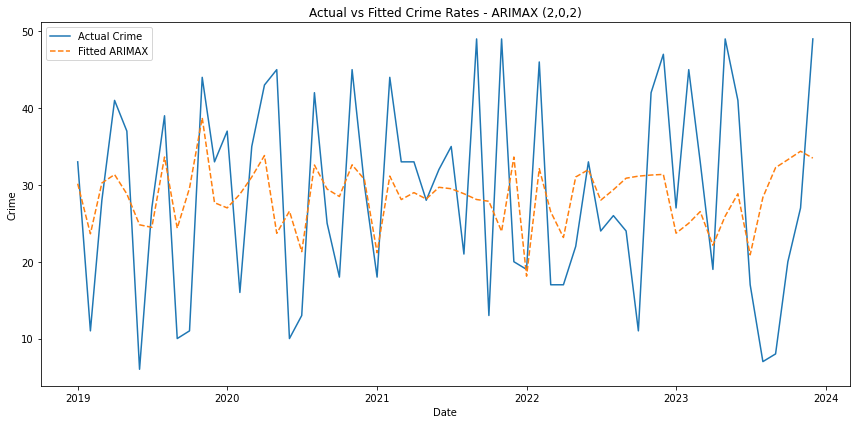

In [22]:


# Predict in-sample (fitted values)
fitted = best_model1.predict(start=0, end=len(nairobi_crime)-1, exog=exog_vars)

plt.figure(figsize=(12, 6))
plt.plot(nairobi_crime, label='Actual Crime')
plt.plot(fitted, label='Fitted ARIMAX', linestyle='--')
plt.title('Actual vs Fitted Crime Rates - ARIMAX (2,0,2)')
plt.xlabel('Date')
plt.ylabel('Crime')
plt.legend()
plt.tight_layout()
plt.show()


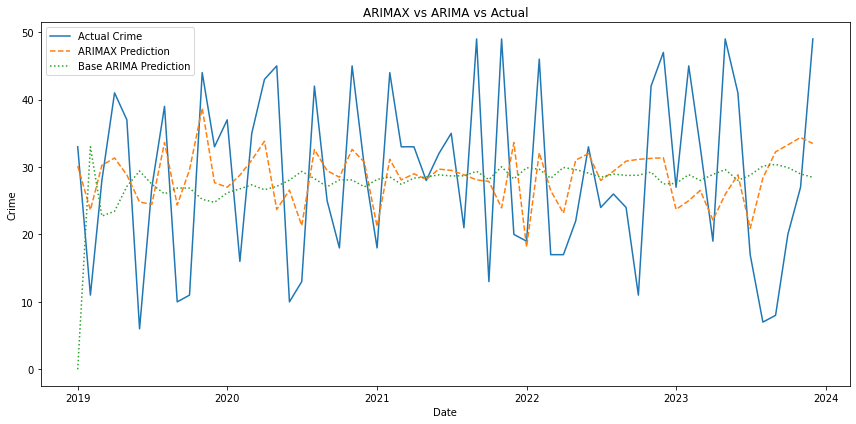

In [23]:
# Fit ARIMA without exogenous variables
base_model1 = sm.tsa.ARIMA(nairobi_crime, order=best_order).fit()
base_pred = arima_result.predict(start=0, end=len(nairobi_crime)-1)

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(nairobi_crime, label='Actual Crime')
plt.plot(fitted, label='ARIMAX Prediction', linestyle='--')
plt.plot(base_pred, label='Base ARIMA Prediction', linestyle=':')
plt.title('ARIMAX vs ARIMA vs Actual')
plt.xlabel('Date')
plt.ylabel('Crime')
plt.legend()
plt.tight_layout()
plt.show()


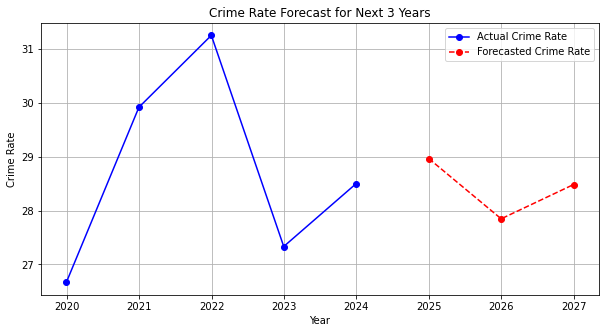

In [24]:

# Forecast for the next 3 years (36 months)
forecast_steps = 36

# Ensure future exogenous variables exist
if len(exog_vars) < forecast_steps:
    raise ValueError("Not enough future exogenous variables. Consider extending the dataset.")

# Extract future exogenous variables
future_exog = exog_vars.iloc[-forecast_steps:].values

# Forecast next 36 months
forecast_values = best_model1.forecast(steps=forecast_steps, exog=future_exog)

# Convert forecasted values to a DataFrame with correct date index
forecast_dates = pd.date_range(start=nairobi_crime.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq="M")
forecast_series = pd.Series(forecast_values.values, index=forecast_dates)

# Aggregate to yearly averages
forecast_yearly = forecast_series.resample('Y').mean()

# Generate future years
future_years = forecast_yearly.index.year

# Plot actual vs forecasted values
plt.figure(figsize=(10, 5))
plt.plot(nairobi_crime.resample('Y').mean(), label="Actual Crime Rate", color="blue", marker="o")
plt.plot(forecast_yearly, label="Forecasted Crime Rate", color="red", linestyle="dashed", marker="o")
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.title("Crime Rate Forecast for Next 3 Years")
plt.legend()
plt.grid(True)
plt.show()


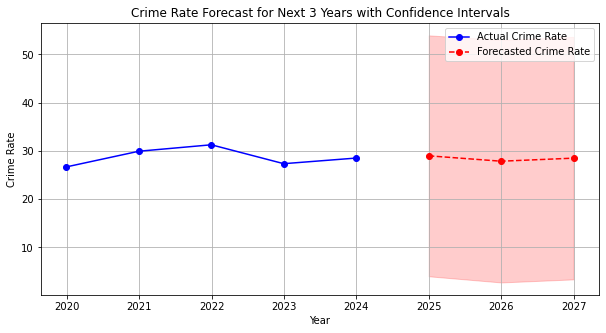

In [25]:
# Get forecast results with confidence intervals
forecast_results = best_model1.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)  # 95% confidence interval

# Convert to yearly averages
forecast_yearly = forecast_mean.resample('Y').mean()
conf_int_yearly = conf_int.resample('Y').mean()

# Plot actual vs forecast with confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(nairobi_crime.resample('Y').mean(), label="Actual Crime Rate", color="blue", marker="o")
plt.plot(forecast_yearly, label="Forecasted Crime Rate", color="red", linestyle="dashed", marker="o")
plt.fill_between(conf_int_yearly.index, conf_int_yearly.iloc[:, 0], conf_int_yearly.iloc[:, 1], color='red', alpha=0.2)
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.title("Crime Rate Forecast for Next 3 Years with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()
